# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [0]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from data_utils import get_CIFAR10_data
from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [27]:
from layer_utils import *

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [0]:
from builtins import range
from builtins import object
import numpy as np

class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        self.params['W1']= np.random.normal(loc=0, scale=weight_scale, size=(input_dim,hidden_dim))
        self.params['b1']= np.zeros(hidden_dim)
        self.params['W2']= np.random.normal(loc=0, scale=weight_scale, size=(hidden_dim,num_classes))
        self.params['b2']= np.zeros(num_classes)

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################   
        
        hidden_layer,cache_hidden_layer = affine_relu_forward(X, self.params['W1'], self.params['b1'])
        scores,cache_scores = affine_forward(hidden_layer,self.params['W2'],self.params['b2'])        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dscores = softmax_loss(scores, y)
        
        dx1, grads['W2'], grads['b2']=affine_backward(dscores,cache_scores)
        
        dx,grads['W1'],grads['b1'] = affine_relu_backward(dx1,cache_hidden_layer)       
       
        grads['W2']+=self.reg*self.params['W2']
        grads['W1']+=self.reg*self.params['W1']
        loss+=0.5*self.reg*(np.sum(self.params['W1']**2)+np.sum(self.params['W2']**2))  
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 dropout=1, normalization=None, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}
        self.drop = dropout

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################
        dims =[input_dim]+hidden_dims +[num_classes]
        for i in range(self.num_layers):
          self.params['b%d' % (i+1)] = np.zeros(dims[i + 1])
          self.params['W%d' % (i+1)] = np.random.normal(loc=0, scale=weight_scale, size=(dims[i],dims[i+1]))        
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
            if seed is not None:
                self.dropout_param['seed'] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization=='batchnorm':
            self.bn_params = [{'mode': 'train'} for i in range(self.num_layers - 1)]
        if self.normalization=='layernorm':
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param['mode'] = mode
        if self.normalization=='batchnorm':
            for bn_param in self.bn_params:
                bn_param['mode'] = mode
        scores = None
        cache={}
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        
        num_layers=self.num_layers
        drop_cache={}
        layer = {}
        layer[0] = X
        cache_layer = {}

        for i in range(1, num_layers):
           layer[i], cache_layer[i] = affine_relu_forward(layer[i - 1], self.params['W%d' % i],self.params['b%d' % i])
           if(self.use_dropout):
              layer[i], drop_cache[i] = dropout_forward(layer[i],self.dropout_param)
        
        WLast = 'W%d' % self.num_layers
        bLast = 'b%d' % self.num_layers
        scores, cache_scores = affine_forward(layer[self.num_layers - 1],
                                          self.params[WLast],
                                          self.params[bLast])       
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dscores = softmax_loss(scores,y)        
        loss+=0.5*self.reg*np.sum(self.params['W'+str(num_layers)]**2)        
        dx,grads['W'+str(num_layers)],grads['b'+str(num_layers)] = affine_backward(dscores,cache_scores)        
        grads['W'+str(num_layers)]+=self.reg*self.params['W'+str(num_layers)]
        for i in range(num_layers-1, 0, -1):          
          if(self.use_dropout):
            dx=dropout_backward(dx,drop_cache[i])
          dx,grads['W'+str(i)],grads['b'+str(i)]=affine_relu_backward(dx,cache_layer[i])          
          loss+=0.5*self.reg*np.sum(self.params['W'+str(i)]**2)        
          grads['W'+str(i)]+=self.reg*self.params['W'+str(i)]
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `cs231n/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [12]:
from layers import dropout_forward, dropout_backward
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `cs231n/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [19]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:


# Fully-connected nets with Dropout
In the file `cs231n/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the net receives a value that is not 1 for the `dropout` parameter, then the net should add dropout immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [32]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [33]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.878000; val_acc: 0.269000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.275000
(Epoch 10 / 25) train acc: 0.888000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.926000; val_acc: 0.278000
(Epoch 12 / 25) train acc: 0.960000; val_acc: 0.302000
(Epoch 13 / 25) train acc: 0.964000; val_acc: 0.306000
(Epoch 14 / 25) train acc: 0.966000; val_acc: 0.309000
(Epoch 15 / 25) train acc: 0.976000; val_acc: 0.288000
(Epoch 16 / 25) train acc: 0.988000; val_acc: 0.301000
(Epoch 17 / 25) train acc: 0.988000; v

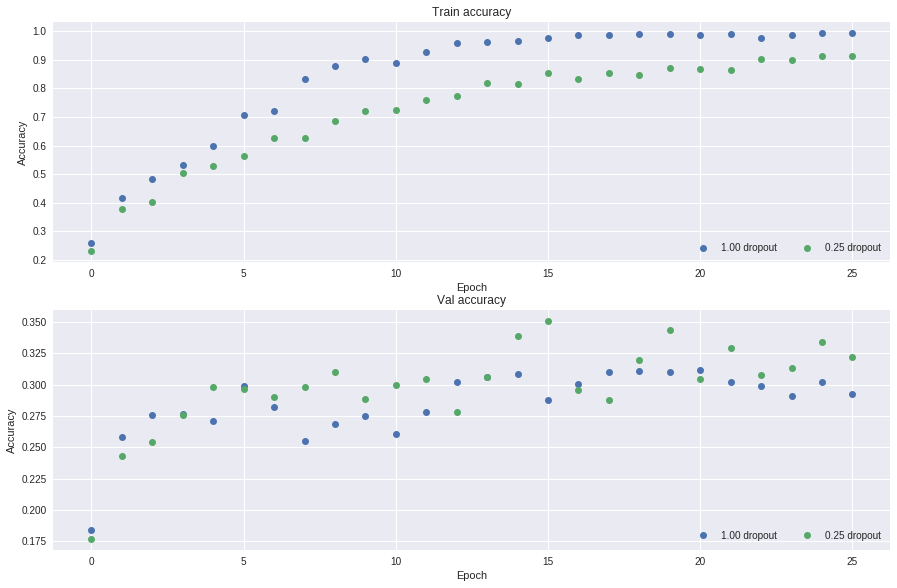

In [34]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:


## Inline Question 3:
Suppose we are training a deep fully-connected network for image classification, with dropout after hidden layers (parameterized by keep probability p). How should we modify p, if at all, if we decide to decrease the size of the hidden layers (that is, the number of nodes in each layer)?

## Answer:
